In [146]:
# Import Libraries

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
import librosa
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Set boolean

Light = False
Ac = False
Security = False
Music = False
Tv = False
WashM = False

# Split dataset

In [147]:
path = "projaudio"

data_dir = pathlib.Path(path)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = data_dir,
    batch_size = 8,
    validation_split = 0.2,
    seed = 0,
    output_sequence_length = 88200,
    subset = "both"
)

label_names = np.array(train_ds.class_names)
print(label_names)

Found 184 files belonging to 8 classes.
Using 148 files for training.
Using 36 files for validation.


['1_lights_on' '2_lights_off' '3_ac_on' '4_ac_off' '5_lock_openings'
 '6_play_music' '7_tv_on' '8_washing_machine_on']


In [148]:
train_ds.element_spec

(TensorSpec(shape=(None, 88200, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

# Preprocessing

In [149]:
def squeeze(audio, label):
    print("Before squeeze:", audio.shape)
    if len(audio.shape) == 3:
        audio = tf.reduce_mean(audio, axis=-1)
    print("After squeeze:", audio.shape)
    return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

Before squeeze: (None, 88200, None)
After squeeze: (None, 88200)
Before squeeze: (None, 88200, None)
After squeeze: (None, 88200)


In [150]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

Example spectrograms shape: (8, 88200)
Example labels shape: (8,)


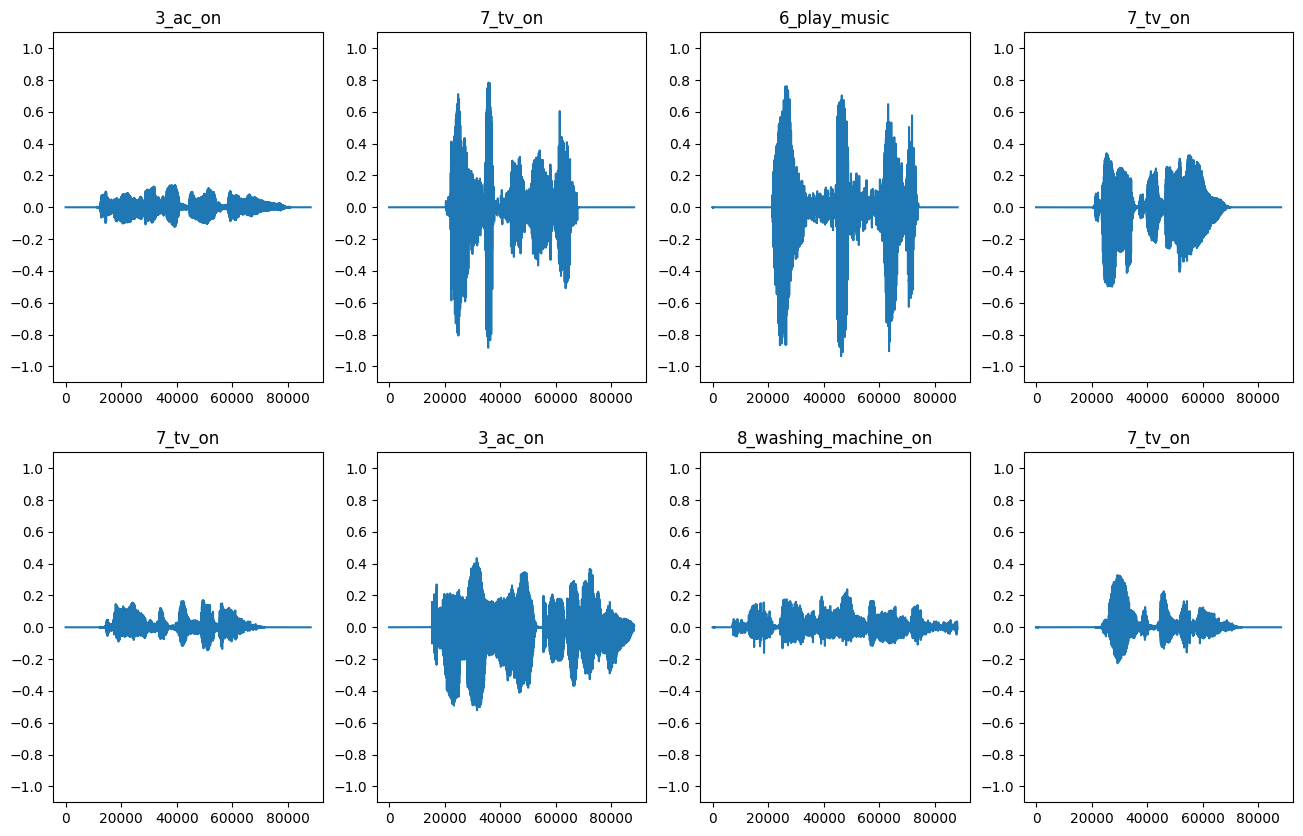

In [151]:
# Take dataset sample
for example_spec, example_spec_label in train_ds.take(1):
    print("Example spectrograms shape:", example_spec.shape)
    print("Example labels shape:", example_spec_label.shape)

plt.figure(figsize=(16, 10))
rows = 2
cols = 4
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_spec[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_spec_label[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [152]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform,
        frame_length = 256,
        frame_step = 128
    )

    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [153]:
print(example_spec[0])
print(example_spec_label[0])

tf.Tensor(
[ 0.0000000e+00  0.0000000e+00 -1.5258789e-05 ...  3.0517578e-05
 -3.0517578e-05  0.0000000e+00], shape=(88200,), dtype=float32)
tf.Tensor(2, shape=(), dtype=int32)


In [154]:
# Take example audios
for i in range(3):
    label = label_names[example_spec_label[i].numpy()]
    waveform = example_spec[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=44100))

Label: 3_ac_on
Waveform shape: (88200,)
Spectrogram shape: (688, 129, 1)
Audio playback


Label: 7_tv_on
Waveform shape: (88200,)
Spectrogram shape: (688, 129, 1)
Audio playback


Label: 6_play_music
Waveform shape: (88200,)
Spectrogram shape: (688, 129, 1)
Audio playback


In [155]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

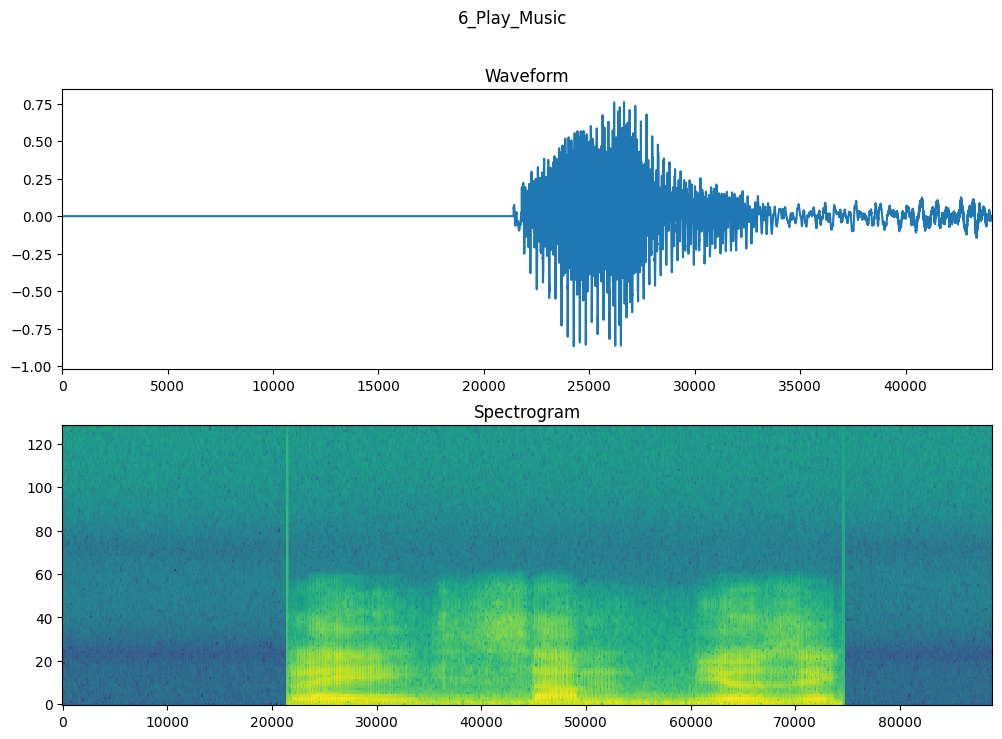

In [156]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 44100])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [157]:
def make_spec_ds(ds):
    return ds.map(
        map_func = lambda audio, label: (get_spectrogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [158]:
train_spec_ds = make_spec_ds(train_ds)
val_spec_ds = make_spec_ds(val_ds)
test_spec_ds = make_spec_ds(test_ds)

In [159]:
# Take dataset sample
for example_spectrograms, example_spect_labels in train_spec_ds.take(1):
    print("Example spectrograms shape:", example_spectrograms.shape)
    print("Example labels shape:", example_spect_labels.shape)
    break

Example spectrograms shape: (8, 688, 129, 1)
Example labels shape: (8,)


# Train model

In [160]:
train_spec_ds = train_spec_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spec_ds = val_spec_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spec_ds = test_spec_ds.cache().prefetch(tf.data.AUTOTUNE)

In [161]:
# arsitektur CNN

input_shape = example_spectrograms.shape[1:]
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spec_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    # input layer
    layers.Input(shape=input_shape),
    # resize layer -> resize spectrogram agar seragam
    layers.Resizing(32, 32),
    # normalize layer -> data dalam satu range sama semua
    norm_layer,
    # hidden layer -> maxpooling, dropout, convolution
    layers.Conv2D(32, 3, activation="relu"),
    layers.Conv2D(64, 3, activation="relu"),

      # maxpooling -> avoid overfitting
    layers.MaxPooling2D(),
      # randomly drop data -> avoid overfitting
    layers.Dropout(0.2),

    # flatten layer
    layers.Flatten(),
    # dense layer
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.1),

    # output layer
    layers.Dense(len(label_names))
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [162]:
# Compile model

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [163]:
# Fit model

EPOCHS = 10
history = model.fit(
    train_spec_ds,
    validation_data=val_spec_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1534 - loss: 2.0840 - val_accuracy: 0.6875 - val_loss: 1.4537
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7457 - loss: 1.2092 - val_accuracy: 0.8125 - val_loss: 1.3067
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8040 - loss: 0.5630 - val_accuracy: 0.7500 - val_loss: 0.8022
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8923 - loss: 0.4423 - val_accuracy: 0.8750 - val_loss: 0.3421
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9531 - loss: 0.2862 - val_accuracy: 0.9375 - val_loss: 0.9104
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9351 - loss: 0.2320 - val_accuracy: 0.8750 - val_loss: 1.1744
Epoch 6: early stopping


In [164]:
# Evaluate model

model.evaluate(test_spec_ds, return_dict=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8938 - loss: 0.3753 


{'accuracy': 0.8500000238418579, 'loss': 0.4548036456108093}

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


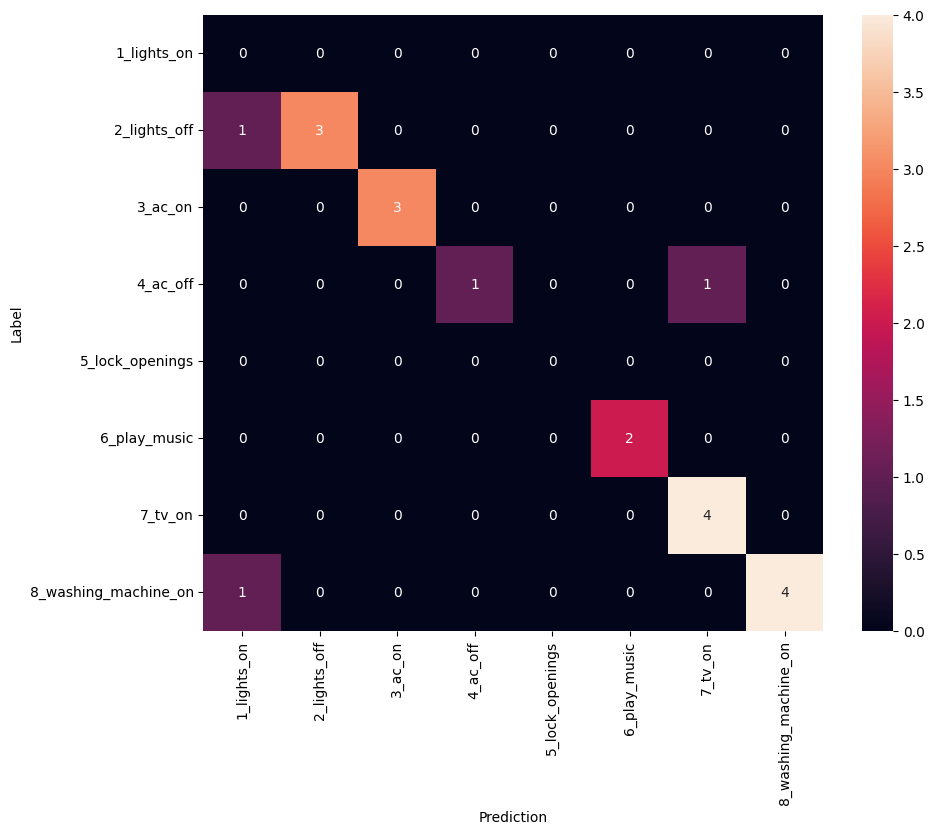

In [165]:
# Confusion matrix

y_pred = model.predict(test_spec_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spec_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx,
    xticklabels=label_names,
    yticklabels=label_names,
    annot=True, fmt='g'
)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

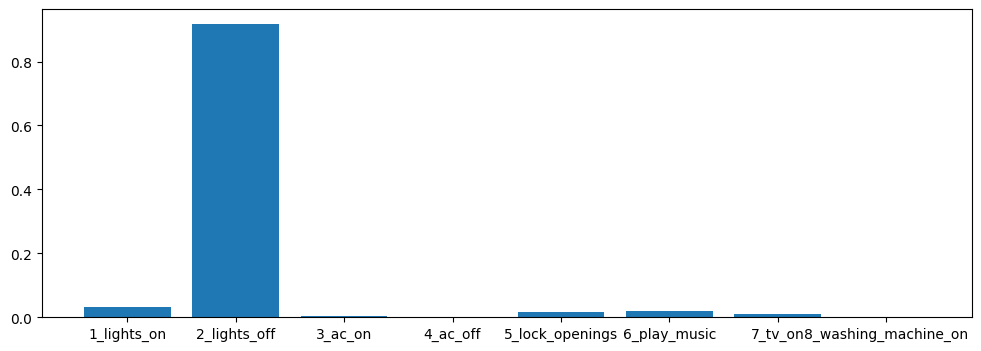

In [167]:
# Testing output

x = data_dir/"2_lights_off/a20302.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=88200,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = label_names
plt.figure(figsize=(12,4))
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.show()

display.display(display.Audio(waveform, rate=44100))

# Input microphone audio

In [123]:
import pyaudio
import wave

audio = pyaudio.PyAudio()
stream = audio.open(format=pyaudio.paInt16, channels=1, rate=44100, input=True, frames_per_buffer=1024)

frames = []

try:
    print("Press stop button to stop recording...")
    while True:
        data = stream.read(1024)
        frames.append(data)
        
except KeyboardInterrupt:
    print("Stopped recording.")
    pass

stream.stop_stream()
stream.close()
audio.terminate()

sound_file = wave.open("output.wav", "wb")
sound_file.setnchannels(1)
sound_file.setsampwidth(audio.get_sample_size(pyaudio.paInt16))
sound_file.setframerate(44100)
sound_file.writeframes(b"".join(frames))
sound_file.close()

Press stop button to stop recording...
Stopped recording.


# Output Command

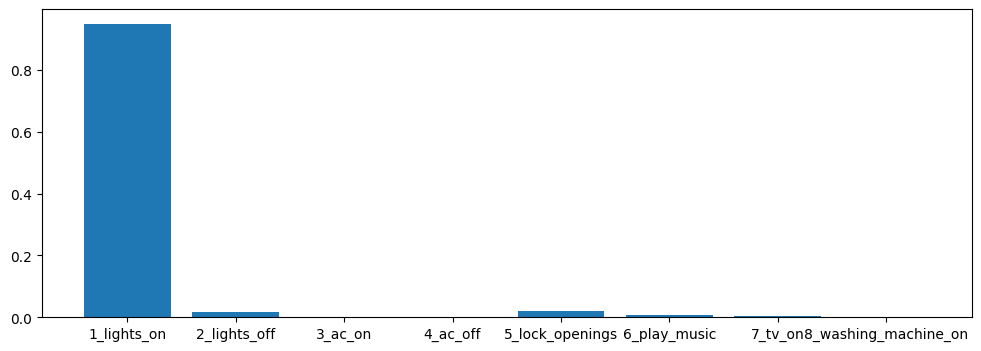

Command: 1_lights_on
The Lights are Already On.


In [170]:
x = "output.wav"
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=88200,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)[0]
x_labels = label_names
plt.figure(figsize=(12,4))
plt.bar(x_labels, tf.nn.softmax(prediction))
plt.show()

most_likely_command = prediction.numpy().argsort()[-1]
print("Command:", label_names[most_likely_command])

if label_names[most_likely_command] == "1_lights_on":
  if Light == True:
    print('The Lights are Already On.')
  else:
    print('Turning the Lights On...')
  Light = True
elif label_names[most_likely_command] == '2_lights_off':
  if Light == True:
    print('Turning the Lights Off...')
  else:
    print('The Lights are Already Off')
  Light = False
elif label_names[most_likely_command] == '3_ac_on':
  if Ac == True:
    print('The Air Conditioner is Already On')
  else:
    print('Turning the Air Conditioner On...')
  Light = True
elif label_names[most_likely_command] == '4_ac_off':
  if Ac == True:
    print('Turning the Air Conditioner Off...')
  else:
    print('The Air Conditioner is Already Off')
  Ac = False
elif label_names[most_likely_command] == '5_lock_openings':
  if Security == True:
    print('Home Security is Already On')
  else:
    print('Turning the Home Security On...')
  Security = True
elif label_names[most_likely_command] == '6_play_music':
  if Music == True:
    print('The Music is Already On')
  else:
    print('Turning the Music On...')
  Music = True
elif label_names[most_likely_command] == '7_tv_on':
  if Tv == True:
    print('The Television is Already On')
  else:
    print('Turning the Television On...')
  Tv = True
elif label_names[most_likely_command] == '8_washing_machine_on':
  if WashM == True:
    print('The Washing Machine is Already On')
  else:
    print('Turning the Washing Machine On...')
  WashM = True